## Задача
Прогнозируем цену акций на следующий день, используя простую скользящую среднюю
Учитывая цены за последние N дней, мы делаем прогноз на день N + 1.

Данные взяты с сайта Yahoo:
https://finance.yahoo.com/quote/VTI/history?p=VTI

https://docs.google.com/presentation/d/1JDLuXWOW3t6cKd7LpxC0HgP--5mTegsfsXDShKEQYDY/edit?usp=sharing

Цели проекта:
    Создание программного обеспечения, позволяющего прогнозировать поведение фондового рынка.
    Коммерческий интерес
    Найти лучший метод прогнозирования цены акций на рынке

**Скользящая средняя**

В методе скользящего среднего прогнозируемое значение будет средним из предыдущих N значений. В данном контексте это означает, что мы устанавливаем текущую скорректированную цену закрытия как среднее значение скорректированной цены закрытия за предыдущие N дней. Необходимо настроить гиперпараметр N.

In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error


In [2]:
np.warnings.filterwarnings('ignore')

%matplotlib inline

stk_path = "VTI.csv"
test_size = 0.2                 # размер тестовой выборки
cv_size = 0.2                   # размер данных для кросс-валидации
Nmax = 21                       # Nmax - это максимальное значение N, которое мы собираемся протестировать
fontsize = 14
ticklabelsize = 14

Данные, представленые в формате CSV, содержат такие параметры как: 

Дата, Открытие, Максимум, Минимум, Закрытие, Скорректированное закрытие, Объем.

### Общие функции

In [3]:
def get_preds_mov_avg(df, target_col, N, pred_min, offset):
    """
     Входы
         df: фрейм данных со значениями, которые вы хотите предсказать. Может быть любой длины.
         target_col: имя столбца, который вы хотите предсказать, например. "adj_close"
         N: получить прогноз на временном шаге t, используя значения из t-1, t-2, ..., t-N
         pred_min: все прогнозы должны быть> = pred_min
         смещение: для df мы делаем прогнозы только для df [смещение:]. например смещение может быть размером обучающего набора
     Выходы
         pred_list: список. Прогнозы для target_col. np.array длины len (df) -offset.
    """
    pred_list = df[target_col].rolling(window = N, min_periods=1).mean() # len(pred_list) = len(df)
    
    # Добавление временного шага к прогнозированию
    pred_list = np.concatenate((np.array([np.nan]), np.array(pred_list[:-1])))
    
    # Если значение меньше pred_min, установить его равным pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
    
    return pred_list[offset:]

def get_mape(y_true, y_pred): 
    """
    Вычислить среднюю абсолютную процентную ошибку (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Загружаем данные

In [4]:
df = pd.read_csv(stk_path, sep = ",")

# Конвертация столбца Date в формат datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Изменить все заголовки столбцов на нижний регистр и удалить интервалы
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Получить месяц для каждой даты
df['month'] = df['date'].dt.month

# Сортировка по времени
df.sort_values(by='date', inplace=True, ascending=True)

In [5]:
df.head()

,date,open,high,low,close,adj_close,volume,month
0,2019-12-26,163.699997,164.229996,163.630005,164.229996,161.357681,2515000,12
1,2019-12-27,164.610001,164.679993,163.800003,164.080002,161.210297,2356700,12
2,2019-12-30,164.300003,164.380005,162.910004,163.190002,160.335861,4503500,12
3,2019-12-31,163.000000,163.759995,162.720001,163.619995,160.758331,3262400,12
4,2020-01-02,164.679993,164.979996,163.779999,164.979996,162.094574,3291100,1


In [6]:
df.tail()

,date,open,high,low,close,adj_close,volume,month
248,2020-12-18,194.380005,194.470001,192.210007,193.470001,192.687225,4542100,12
249,2020-12-21,191.600006,193.350006,189.820007,192.910004,192.129501,5011900,12
250,2020-12-22,193.309998,193.479996,192.210007,192.949997,192.169327,4336000,12
251,2020-12-23,193.649994,194.220001,193.160004,193.279999,192.498001,3451400,12
252,2020-12-24,192.880005,193.000000,192.240005,192.820007,192.820007,1744000,12


Text(0, 0.5, 'USD')

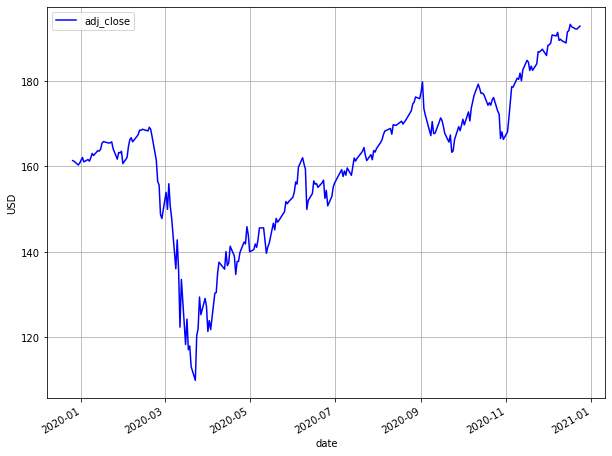

In [7]:
rcParams['figure.figsize'] = 10, 8 

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

### Разделияем выборку на тренировочные и тестовые выборки

In [8]:
# Получить размеры каждого датасета
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Разделение на тренировочную, резюмирующую и тестовую выборки
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 153
num_cv = 50
num_test = 50
train.shape = (153, 8)
cv.shape = (50, 8)
train_cv.shape = (203, 8)
test.shape = (50, 8)


Text(0, 0.5, 'USD')

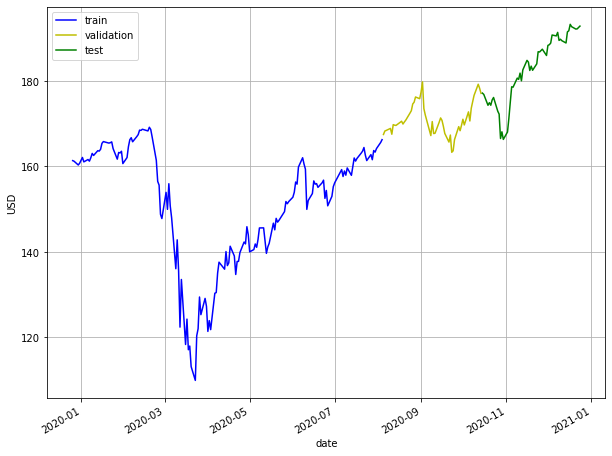

In [9]:
rcParams['figure.figsize'] = 10, 8 

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

### Прогнозирование с использованием скользящей средней

In [10]:
RMSE = []
MAPE = []
for N in range(1, Nmax+1): # N - номер образцов для прогнозирования следующего значения
    est_list = get_preds_mov_avg(train_cv, 'adj_close', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['adj_close'])))
    MAPE.append(get_mape(cv['adj_close'], est_list))
print('RMSE = ' + str(RMSE))
print('MAPE = ' + str(MAPE))
df.head()

RMSE = [2.0194691864767362, 2.142402846294925, 2.4458066409879833, 2.725052280171974, 2.9836043170533837, 3.2231902857630548, 3.406536115168849, 3.5707212148197867, 3.713038477594461, 3.866677236364184, 4.015006995727225, 4.167197970398522, 4.317319026522369, 4.465154324952818, 4.594751677153547, 4.706568483650734, 4.806164676898948, 4.892590373956949, 4.976577548182301, 5.056472836361469, 5.141169214700052]
MAPE = [0.926666800131586, 1.0016633869930693, 1.1372370425068017, 1.3146424734028375, 1.462878454670891, 1.5965786947149996, 1.710163256691084, 1.8059607904138006, 1.8970735161914203, 1.9955747746530959, 2.0871905827551966, 2.1744133551132325, 2.2546080904687407, 2.337363979368739, 2.4077245000825265, 2.466059746416899, 2.512625865424976, 2.563354758256223, 2.6058524660190043, 2.639544304812417, 2.6731548694886995]


,date,open,high,low,close,adj_close,volume,month
0,2019-12-26,163.699997,164.229996,163.630005,164.229996,161.357681,2515000,12
1,2019-12-27,164.610001,164.679993,163.800003,164.080002,161.210297,2356700,12
2,2019-12-30,164.300003,164.380005,162.910004,163.190002,160.335861,4503500,12
3,2019-12-31,163.000000,163.759995,162.720001,163.619995,160.758331,3262400,12
4,2020-01-02,164.679993,164.979996,163.779999,164.979996,162.094574,3291100,1


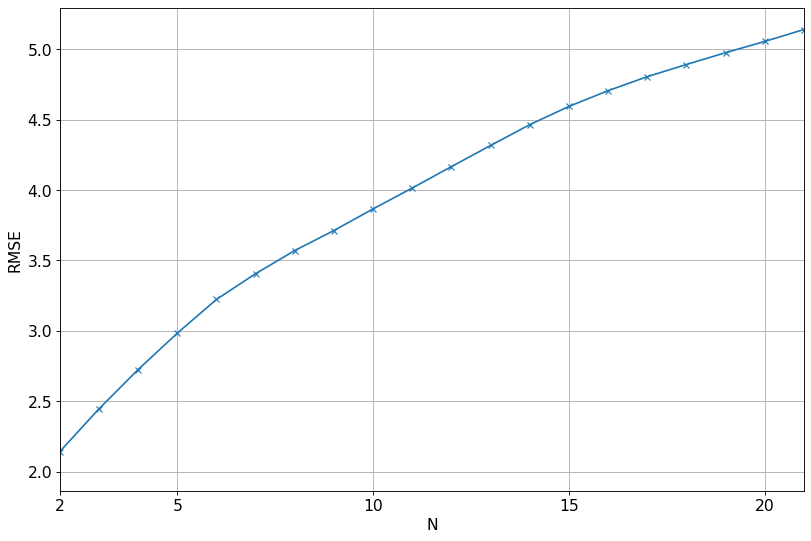

In [14]:
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([2, 21])
plt.xticks([2, 5, 10, 15, 20])
matplotlib.rcParams.update({'font.size': 14})

([<matplotlib.axis.XTick at 0xa241a78>,
 <a list of 5 Text major ticklabel objects>)

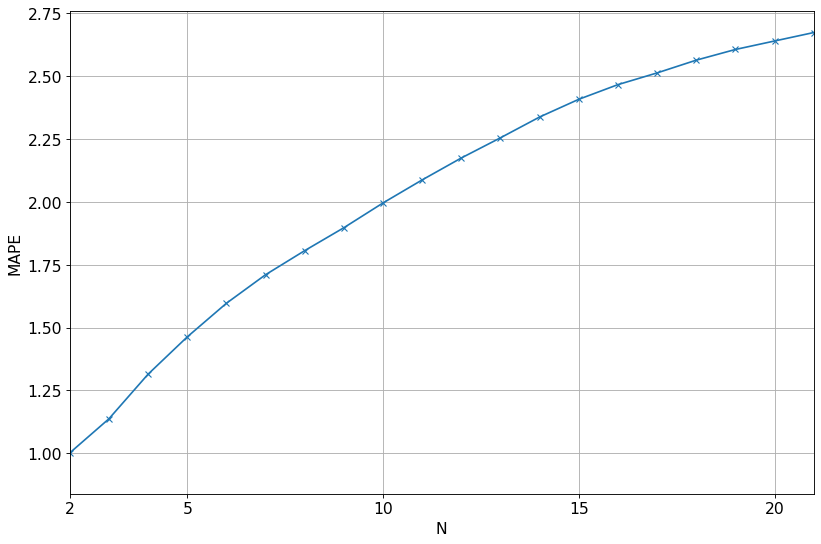

In [15]:
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), MAPE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')
plt.xlim([2, 21])
plt.xticks([2, 5, 10, 15, 20])

In [16]:
N_opt = 2

## График предсказаний на кросс-валидационной выборке

Text(0, 0.5, 'USD')

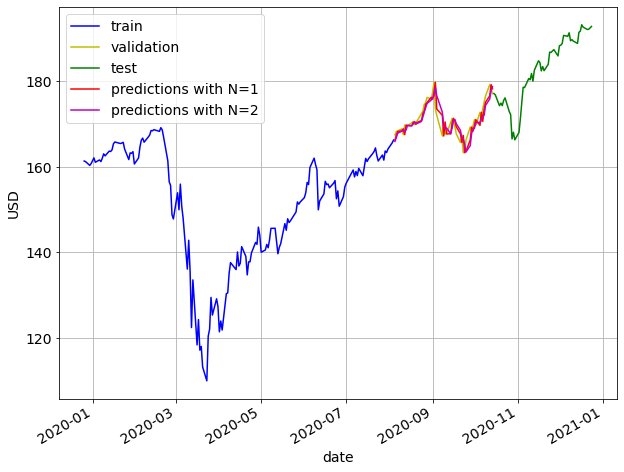

In [17]:
rcParams['figure.figsize'] = 10, 8 

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N2', style='m-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to cv set')

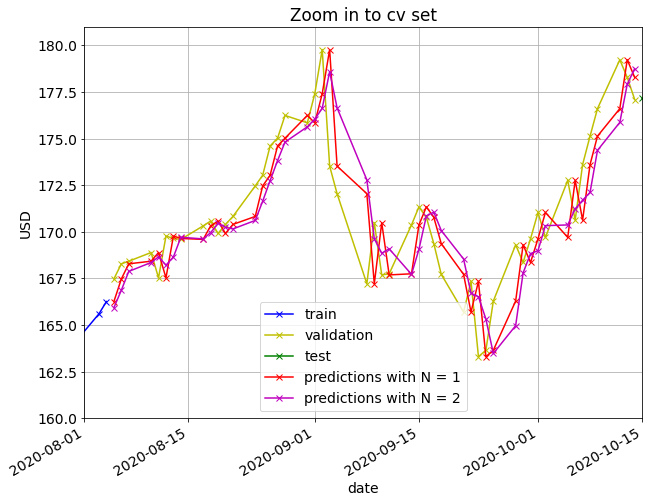

In [19]:
rcParams['figure.figsize'] = 10, 8 

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N2', style='mx-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N = 1', 'predictions with N = 2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2020, 8, 1), date(2020, 10, 15)])
ax.set_ylim([160, 181])
ax.set_title('Zoom in to cv set')

### Финальная модель

In [20]:
est_list = get_preds_mov_avg(df, 'adj_close', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['adj_close'])))
print("MAPE = %0.3f%%" % get_mape(test['adj_close'], est_list))
test.head()

RMSE = 2.064
MAPE = 0.853%


,date,open,high,low,close,adj_close,volume,month,est_N2
203,2020-10-15,175.610001,178.070007,175.160004,177.869995,177.150345,2865300,10,177.683182
204,2020-10-16,178.479996,179.309998,177.550003,177.550003,176.831650,1910200,10,177.120468
205,2020-10-19,178.309998,179.250000,174.619995,175.009995,174.301910,2713800,10,176.990998
206,2020-10-20,175.899994,177.360001,175.240005,175.619995,174.909439,2622900,10,175.566780
207,2020-10-21,175.660004,176.720001,175.020004,175.020004,174.311874,3237200,10,174.605675


Text(0, 0.5, 'USD')

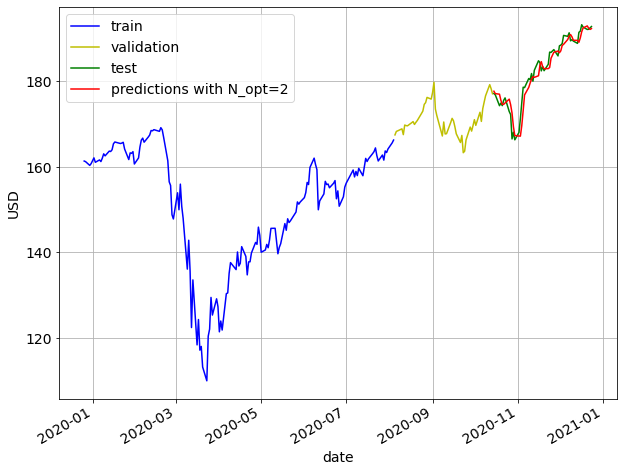

In [21]:
rcParams['figure.figsize'] = 10, 8 

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N2', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

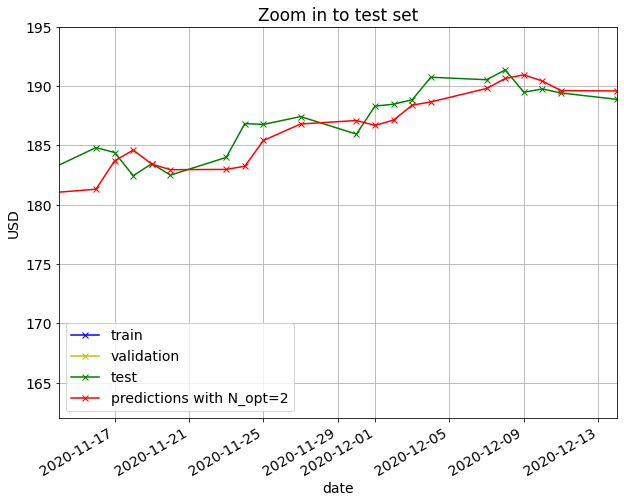

In [26]:
rcParams['figure.figsize'] = 10, 8 

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N2', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2020, 11, 14), date(2020, 12, 14)])
ax.set_ylim([162, 195])
ax.set_title('Zoom in to test set')

(165.0, 195.0)

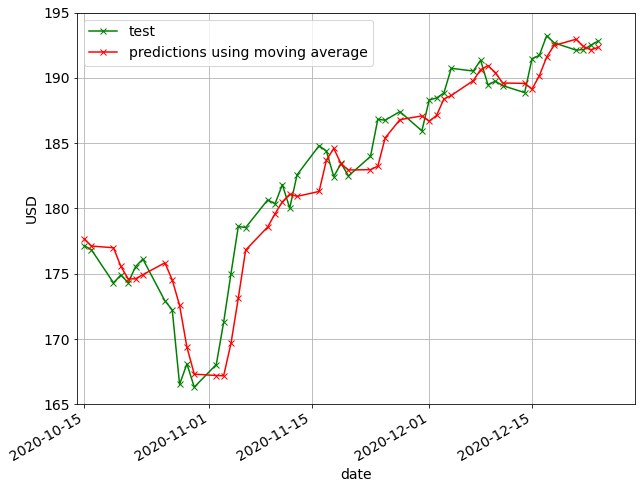

In [25]:
rcParams['figure.figsize'] = 10, 8 
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = test.plot(x='date', y='est_N2', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using moving average'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2020, 10, 14), date(2020, 12, 29)])
ax.set_ylim([165, 195])

In [27]:
test_mov_avg = test
test_mov_avg.to_csv("test_mov_avg.csv")

##### На наборе cv самым низким показателем средней квадратичной ошибки было 1.2 и достигалось при N = 1, то есть используя значение дня t-1 чтобы предсказать значение дня t
##### На наборе test самым низким показателем средней квадратичной ошибки было 1.33 и достигалось при N = 2, то есть используя значение дней t-2 и t-1 для предсказания значения дня t
##### Мы будем использовать значение N_opt = 2, так как цель - метод скользящего среднего
##### На наборе test средняя квадратичная ошибка равнялась 1.27, а показатель средней абсолютной ошибки составил 0.64%